In [ ]:
import librosa
import librosa.display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Audio, display, Image, YouTubeVideo

from sklearn.cluster import DBSCAN

In [ ]:
sr = 22050
hop_length = 512

In [ ]:
df_f_name = '../data/taylor_df.pkl'
df = pd.read_pickle(df_f_name)
df

In [ ]:
y = df['song_wave'].iloc[0]
sec_start = 10
n_secs = 15
loc_start = sec_start * sr
loc_end = (sec_start + n_secs) * sr
Audio(y[loc_start:loc_end], rate=sr)

_____________________________________

# Detecting onset (audio)

In [ ]:
def get_clipped_onset_env(y, sr, hop_length):
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length, aggregate=np.median)
    clipped_onset_env = np.clip(onset_env, 0, np.percentile(onset_env, 99.9))
    return clipped_onset_env

In [ ]:
def get_onset_locs(y, sr, hop_length, val_ofset, windows_per_second, delta, seconds_to_wait, onset_env=None):
    onset_locs = librosa.onset.onset_detect(y, onset_envelope=onset_env, 
                                            sr=sr, hop_length=hop_length, 
                                            pre_max=val_ofset, post_max=val_ofset,
                                            delta=delta, wait=windows_per_second * seconds_to_wait)
    return onset_locs

In [ ]:
def plot_onset_detect(onset_env, onset_locs, sr, hop_length, windows_per_second):
    plt.figure(figsize=(15, 4));

    plt.subplot(1, 2, 1);

    times = librosa.frames_to_time(np.arange(len(onset_env)), sr=sr, hop_length=hop_length)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda t, pos: "{}:{}".format(int(t//60), int(t%60))))

    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[onset_locs], 0, onset_env.max(), color='r', alpha=0.8, label='Selected peaks')

    plt.legend(frameon=True, framealpha=0.8)

    plt.subplot(1, 2, 2);
    secs_to_next_onset = [(x2 - x1) / windows_per_second
                          for x1, x2 in zip(onset_locs[:-1], onset_locs[1:])]
    plt.plot(secs_to_next_onset);
    plt.ylabel('secs to next onset');
    plt.xlabel('onset index');

    plt.tight_layout();

In [ ]:
val_ofset = 1
windows_per_second = 43
delta = 0.2
seconds_to_wait = 3

y = df['song_wave'].iloc[5]

onset_env = get_clipped_onset_env(y, sr, hop_length)
onset_locs = get_onset_locs(y, sr, hop_length, val_ofset, windows_per_second, delta, seconds_to_wait, onset_env)
plot_onset_detect(onset_env, onset_locs, sr, hop_length, windows_per_second)


_____________________________________


# Detecting scenes (video)

In [19]:
from __future__ import print_function
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import scenedetect
from scenedetect.video_manager import VideoManager
from scenedetect.scene_manager import SceneManager
from scenedetect.frame_timecode import FrameTimecode
from scenedetect.stats_manager import StatsManager
from scenedetect.detectors import ContentDetector

In [2]:
calm_down_path = '../data/Taylor_Swift_-_You_Need_To_Calm_Down.mp4'
output_stats_path = '../data/testvideo.stats.csv'

In [3]:
def detect_scenes(input_song_path, output_stats_path):
    video_manager = VideoManager([input_song_path])
    stats_manager = StatsManager()
    scene_manager = SceneManager(stats_manager)
    scene_manager.add_detector(ContentDetector())
    base_timecode = video_manager.get_base_timecode()

    start_time = base_timecode + 20     # 00:00:00.667
    end_time = base_timecode + 20.0     # 00:00:20.000
    # Set video_manager duration to read frames from 00:00:00 to 00:00:20.
    video_manager.set_duration(start_time=start_time, end_time=end_time)

    # Set downscale factor to improve processing speed (no args means default).
    video_manager.set_downscale_factor()

    # Start video_manager.
    video_manager.start()

    # Perform scene detection on video_manager.
    scene_manager.detect_scenes(frame_source=video_manager)

    # Obtain list of detected scenes.
    scene_list = scene_manager.get_scene_list(base_timecode)
    # Like FrameTimecodes, each scene in the scene_list can be sorted if the
    # list of scenes becomes unsorted.

    print('List of scenes obtained:')
    for i, scene in enumerate(scene_list):
        print('    Scene %2d: Start %s / Frame %d, End %s / Frame %d' % (
            i+1,
            scene[0].get_timecode(), scene[0].get_frames(),
            scene[1].get_timecode(), scene[1].get_frames(),))

    stats_manager.save_to_csv(open(output_stats_path, 'w'), base_timecode)
    video_manager.release()

In [4]:
detect_scenes(calm_down_path, output_stats_path)

List of scenes obtained:
    Scene  1: Start 00:00:00.834 / Frame 20, End 00:00:02.836 / Frame 68
    Scene  2: Start 00:00:02.836 / Frame 68, End 00:00:05.589 / Frame 134
    Scene  3: Start 00:00:05.589 / Frame 134, End 00:00:08.383 / Frame 201
    Scene  4: Start 00:00:08.383 / Frame 201, End 00:00:10.844 / Frame 260
    Scene  5: Start 00:00:10.844 / Frame 260, End 00:00:14.097 / Frame 338
    Scene  6: Start 00:00:14.097 / Frame 338, End 00:00:19.686 / Frame 472
    Scene  7: Start 00:00:19.686 / Frame 472, End 00:00:19.186 / Frame 460
Writing 459 frames to CSV...


In [31]:
df = pd.read_csv(output_stats_path)
df.reset_index(inplace=True)
df.columns = df.iloc[0]
df = df.drop([0])
df = df.convert_objects(convert_numeric=True)
df.head()

C:\Users\Rey\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,Frame Number,Timecode,content_val,delta_hue,delta_lum,delta_sat
1,21,00:00:00.876,0.046846,0.020288,0.048131,0.072118
2,22,00:00:00.918,0.094185,0.085903,0.059813,0.136838
3,23,00:00:00.959,0.086501,0.085592,0.075545,0.098364
4,24,00:00:01.001,0.120249,0.136020,0.093069,0.131659
5,25,00:00:01.043,0.202960,0.152103,0.231581,0.225195


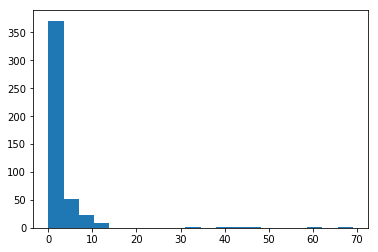

In [32]:
plt.hist(df['delta_hue'], bins=20);

In [49]:
[(i, a) for (i, a) in list(df['delta_hue'].items()) if a > 10]

[(48, 46.854945482866036),
 (114, 60.77971183800623),
 (181, 41.49045950155763),
 (240, 39.87387071651089),
 (280, 12.102141744548286),
 (303, 11.055451713395641),
 (304, 10.95),
 (305, 11.307281931464177),
 (306, 10.456970404984425),
 (307, 10.137266355140186),
 (308, 10.74182242990654),
 (309, 10.81993769470405),
 (310, 10.022313084112149),
 (311, 10.650194704049843),
 (318, 32.854205607476636),
 (452, 69.1242601246106)]

In [ ]:
len(df)

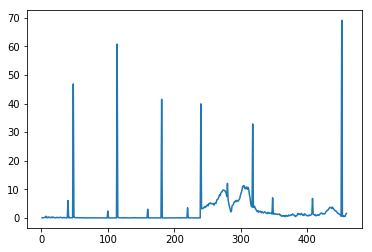

In [38]:
plt.plot(df['delta_hue']);

In [47]:
list(df['delta_hue'].items())

[(1, 0.020288161993769472),
 (2, 0.08590342679127726),
 (3, 0.08559190031152647),
 (4, 0.1360202492211838),
 (5, 0.15210280373831775),
 (6, 0.15292056074766355),
 (7, 0.5648753894080997),
 (8, 0.06366822429906542),
 (9, 0.059112149532710274),
 (10, 0.29840342679127724),
 (11, 0.09867601246105917),
 (12, 0.2838006230529595),
 (13, 0.1930685358255452),
 (14, 0.04127725856697819),
 (15, 0.09104361370716513),
 (16, 0.3575545171339564),
 (17, 0.10833333333333334),
 (18, 0.2269859813084112),
 (19, 0.19887071651090346),
 (20, 0.03220404984423676),
 (21, 0.057866043613707174),
 (22, 0.07702492211838008),
 (23, 0.15837227414330218),
 (24, 0.2294392523364486),
 (25, 0.07021028037383177),
 (26, 0.06927570093457944),
 (27, 0.1183411214953271),
 (28, 0.2265576323987539),
 (29, 0.1640576323987539),
 (30, 0.06958722741433022),
 (31, 0.07858255451713396),
 (32, 0.039447040498442366),
 (33, 0.07328660436137073),
 (34, 0.18450155763239875),
 (35, 0.08333333333333333),
 (36, 0.08274922118380063),
 (37, 0

***********************

# Playground

In [ ]:
librosa.display.waveplot(y, sr=sr);

In [ ]:
n_fft = 2048
hop_length = 512
n_mels = 124

In [ ]:
S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)

In [ ]:
plt.figure(figsize=(10, 6));
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

In [ ]:
np.shape(S_DB)

In [ ]:
10132* windows_per_second

In [ ]:
mfccs = librosa.feature.mfcc(y, sr=sr)
librosa.display.specshow(mfccs, sr=sr, x_axis='time');

In [ ]:
np.shape(S_DB)

In [ ]:
np.shape(mfccs)

In [ ]:
spectral_novelty = librosa.onset.onset_strength(y, sr=sr)

frames = np.arange(len(spectral_novelty))
t = librosa.frames_to_time(frames, sr=sr)

plt.figure(figsize=(15, 4))
plt.plot(t, spectral_novelty, 'r-')
# plt.xlim(0, t.max())
plt.xlabel('Time (sec)')
plt.legend(('Spectral Novelty',))

In [ ]:
windows_per_second = 43
start_idxs = list(range(0, len(spectral_novelty), windows_per_second))
sec_in_snip = 10
windows_in_snip = sec_in_snip * windows_per_second

snippets = [spectral_novelty[s_idx: s_idx + windows_in_snip] for s_idx in start_idxs[:-1]]
snippets = np.array([a for a in snippets if len(a) == windows_in_snip])
np.shape(snippets)

In [ ]:
plt.plot(snippets[0,:]);
plt.plot(snippets[100,:]);


In [ ]:
clustering = DBSCAN(eps=3, min_samples=2).fit(snippets)

In [ ]:
clustering = DBSCAN(eps=3, min_samples=2).fit(S_DB.transpose())

In [ ]:
clustering.labels_

In [ ]:
np.shape(S_DB)